In [1]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
sys.path.append('..') 
import platform
import os
from pathlib import Path
import shutil
from pathlib import Path
import shutil
from utils.behavior.session_utils import load_session_df, parse_session_string
from utils.behavior.lick_analysis import clean_up_licks, parse_lick_trains
from utils.behavior.model_utils import get_param_names_dF, get_model_variables_dF
from scipy.io import loadmat
from itertools import chain
from matplotlib import pyplot as plt
from IPython.display import display
from scipy.signal import find_peaks
from harp.clock import align_timestamps_to_anchor_points
from utils.basics.data_org import *
from utils.photometry.preprocessing import * 
from utils.photometry.plot_utils import align_signal_to_events, color_gradient, plot_FP_with_licks, plot_G_vs_Iso, plot_FP_beh_analysis
from utils.behavior.session_utils import beh_analysis_no_plot
import numpy as np
from scipy.signal import butter, filtfilt, medfilt, sosfiltfilt
from scipy.optimize import curve_fit
import json
from sklearn.linear_model import LinearRegression
from matplotlib.gridspec import GridSpec
import pickle
from aind_fip_dff.utils.preprocess import batch_processing, tc_triexpfit
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import time
from contextlib import redirect_stdout
# %matplotlib inline
# %matplotlib widget
import re
import random
import numpy as np
import os
import re
from scipy.stats import zscore
from scipy.stats import mode



In [2]:
session = 'm699461d20240105'
session_dirs = parse_session_string(session)

In [3]:
beh_session_data, licksL, licksR = load_session_df(session)
s = beh_analysis_no_plot(session)

c:\Users\zhixi\Documents\GitHub\aind_su_etal_2022\notebooks\..\utils\behavior\session_utils.py:53: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  rwd_delay, _ = mode(beh_session_data.loc[response_inds, "rewardTime"].values - beh_session_data.loc[response_inds, "respondTime"].values)


In [4]:
def infer_model_var(session, params, model_name, bias_flag=1, rev_for_flag=0, perturb=None):
    """
    Infer model variables based on the given session and parameters.
    
    Parameters:
        session (object): Session data.
        params (np.array): Model parameters.
        model_name (str): Name of the model.
        bias_flag (int, optional): Default is 1.
        rev_for_flag (int, optional): Default is 0.
        perturb (list, optional): Perturbation settings. Default is None.
    
    Returns:
        dict: Model variables with computed Q-values and likelihoods.
    """

    t = {}
    t["params"] = params

    # Get session behavior
    o = beh_analysis_no_plot_opMD(session, simpleFlag=1)
    outcome = np.abs(np.array(o["allRewards"]))
    choice = np.array(o["allChoices"])
    choice[choice < 0] = 0  # Convert negative choices to 0
    ITI = o["timeBtwn"]
    
    tmp_struct = []
    
    # Process models
    for currS in range(params.shape[0]):
        if perturb is None:
            tmp = get_model_variables_dF(model_name, params[currS, :], choice, outcome)
        # else: # to be updated when add back laser stimulation analysis
        #     tmp = get_model_variables_laser_dF(model_name, params[currS, :], choice, outcome, o["laser"])
        
        tmp_struct.append(tmp)

    # Handle infinite values
    inf_inds = []
    mdl_var_names = list(tmp_struct[0].keys())

    for currV in mdl_var_names:
        if "Q" not in currV:  # Exclude Q-values
            tmp = np.column_stack([tmp_struct[currS][currV] for currS in range(len(tmp_struct))])
            inf_mask = np.isinf(tmp)
            
            if np.any(inf_mask):
                inf_cols = np.where(np.any(inf_mask, axis=0))[0]
                inf_inds.extend(inf_cols.tolist())

            tmp[:, inf_inds] = np.nan
            t[currV] = np.nanmean(tmp, axis=1)

    # Compute Q-values separately
    tmpQ_L = np.column_stack([tmp_struct[currS]["Q"][:, 0] for currS in range(len(tmp_struct))])
    tmpQ_R = np.column_stack([tmp_struct[currS]["Q"][:, 1] for currS in range(len(tmp_struct))])

    tmpQ_L[:, inf_inds] = np.nan
    tmpQ_R[:, inf_inds] = np.nan

    t["Q"] = np.column_stack([np.nanmean(tmpQ_L, axis=1), np.nanmean(tmpQ_R, axis=1)])

    return t


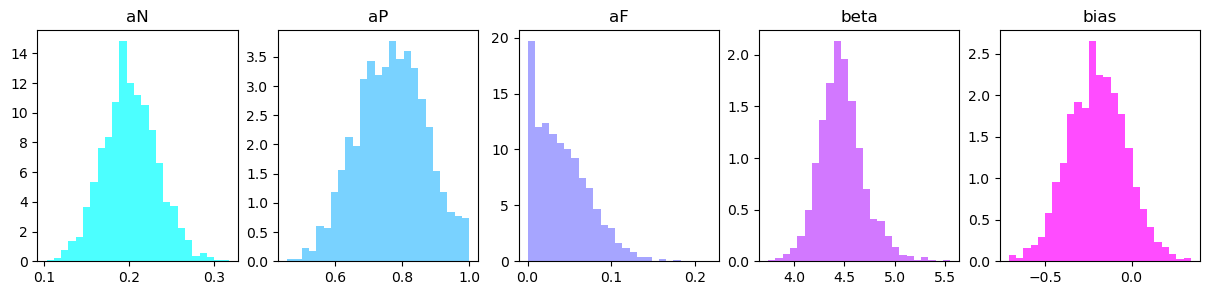

In [15]:
def get_stan_model_params_samps_only(animal_name, category, model_name, num_samps, 
                                     bias_flag=1, session_params_flag=1, 
                                     session_name=None, plot_flag=0):
    """
    Load model parameters from Stan samples.

    Parameters:
        animal_name (str): Name of the animal.
        category (str): Category of the model.
        model_name (str): Name of the model.
        num_samps (int): Number of samples.
        bias_flag (int, optional): Default is 1.
        session_params_flag (int, optional): Default is 1.
        session_name (str, optional): Specific session name. Default is None.
        plot_flag (int, optional): Whether to plot histograms. Default is 0.

    Returns:
        params (np.array): Extracted parameter samples.
        model_name (str): Name of the model.
        ll (float or np.array): Log likelihood values.
        no_session (bool): Flag indicating if session was not found.
    """

    # Get system-specific root path
    root = curr_computer()  # Assumed function to get base path
    param_names = get_param_names_dF(model_name, bias_flag)  # Get parameter names

    # Construct sample file name
    if re.match(r'^[A-Za-z]', animal_name):
        samp_file = f"{animal_name}{category}_{model_name}"
    else:
        samp_file = f"m{animal_name}{category}_{model_name}"

    # Construct paths
    path = os.path.join(root, animal_name, f"{animal_name}sorted", "stan", 
                        "bernoulli", model_name, category)
    model_path = os.path.join(path, f"{samp_file}.mat")

    # Initialize variables
    no_session = False
    params = np.full((num_samps, len(param_names)), np.nan)
    ll = np.nan

    # Load .mat file
    try:
        mat_data = loadmat(model_path)
    except FileNotFoundError:
        print(f"Error: File {model_path} not found.")
        return params, model_name, ll, no_session

    # Extract session index if sessionParamsFlag is enabled
    if session_params_flag and session_name:
        day_list = mat_data.get('dayList', [])
        session_ind = next((i for i, day in enumerate(day_list) if session_name in str(day)), None)
        if session_ind is None:
            no_session = True
            return params, model_name, ll, no_session

    # Load samples from the mat file
    if samp_file in mat_data:
        samples = mat_data[samp_file]
    else:
        print(f"Error: '{samp_file}' not found in .mat file.")
        return params, model_name, ll, no_session

    # Select valid non-divergent samples
    divergent = np.array(np.squeeze(samples['divergent__'][0][0])) < 1
    valid_inds = np.where(divergent)[0]
    if len(valid_inds) < num_samps:
        print("Warning: Not enough valid samples available.")
        return params, model_name, ll, no_session
    inds = random.sample(list(valid_inds), num_samps)

    # Extract parameter samples
    for i, param in enumerate(param_names):
        if session_params_flag:
            tmp = samples[param][0][0][:, session_ind]  # Extract session-specific parameters
        else:
            if param != "bias":
                tmp = samples[f"mu_{param}"][0][0]  # Extract population-level parameters
            else:
                tmp = np.zeros(len(samples[0][0]['beta']))  # Bias is set to zero
        params[:, i] = tmp[inds]

    # Extract log-likelihood if session-specific parameters are used
    if session_params_flag:
        ll = samples["log_lik"][0][0][inds, session_ind]

    # Plot histograms if required
    if plot_flag:
        plt.figure(figsize=(len(param_names) * 3, 3))
        colors = plt.cm.cool(np.linspace(0, 1, len(param_names)))
        for i, param in enumerate(param_names):
            plt.subplot(1, len(param_names), i + 1)
            plt.hist(params[:, i], bins=25, color=colors[i], alpha=0.7, density=True)
            plt.title(param)
        plt.show()

    return params, model_name, ll, no_session

params, model_name, ll, no_session = get_stan_model_params_samps_only(session_dirs['aniName'], 'good', '5params', 2000, session_name=session, plot_flag=True)
